# Aadhaar as a Societal Seismograph  
## Detecting Inclusion & Mobility Signals from Identity System Data

This notebook explores how aggregated Aadhaar enrolment and demographic update data
can be modeled as *passive societal signals* to identify patterns, transitions,
and stress zones that support informed decision-making.

*Note: This analysis is fully aggregate, anonymized, and non-causal by design.*


## Problem Statement

UIDAI manages continuous, nation-scale data on Aadhaar enrolments and updates.
While traditionally used for reporting and compliance, this data also contains
latent signals of societal change.

### Objective
To design a signal-based analytical framework that:
- Identifies inclusion and mobility patterns
- Detects structural transitions and anomalies
- Translates insights into actionable, policy-relevant recommendations


In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

# Visualization settings
plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 5)

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)


In [243]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [244]:
enrolment_files = sorted(
    glob.glob("/content/drive/MyDrive/api_data_aadhar_enrolment/*.csv")
)

demographic_files = sorted(
    glob.glob("/content/drive/MyDrive/api_data_aadhar_demographic/*.csv")
)

enrolment_files, demographic_files

(['/content/drive/MyDrive/api_data_aadhar_enrolment/api_data_aadhar_enrolment_0_500000.csv',
  '/content/drive/MyDrive/api_data_aadhar_enrolment/api_data_aadhar_enrolment_1000000_1006029.csv',
  '/content/drive/MyDrive/api_data_aadhar_enrolment/api_data_aadhar_enrolment_500000_1000000.csv'],
 ['/content/drive/MyDrive/api_data_aadhar_demographic/api_data_aadhar_demographic_0_500000.csv',
  '/content/drive/MyDrive/api_data_aadhar_demographic/api_data_aadhar_demographic_1000000_1500000.csv',
  '/content/drive/MyDrive/api_data_aadhar_demographic/api_data_aadhar_demographic_1500000_2000000.csv',
  '/content/drive/MyDrive/api_data_aadhar_demographic/api_data_aadhar_demographic_2000000_2071700.csv',
  '/content/drive/MyDrive/api_data_aadhar_demographic/api_data_aadhar_demographic_500000_1000000.csv'])

In [245]:
# Load enrolment data
enrol_df = pd.concat(
    [pd.read_csv(f) for f in enrolment_files],
    ignore_index=True
)

# Load demographic update data
demo_df = pd.concat(
    [pd.read_csv(f) for f in demographic_files],
    ignore_index=True
)

print("Enrolment data shape:", enrol_df.shape)
print("Demographic update data shape:", demo_df.shape)


Enrolment data shape: (1006029, 7)
Demographic update data shape: (2071700, 6)


In [246]:
enrol_df.head(), demo_df.head()

(         date          state          district  pincode  age_0_5  age_5_17  \
 0  02-03-2025      Meghalaya  East Khasi Hills   793121       11        61   
 1  09-03-2025      Karnataka   Bengaluru Urban   560043       14        33   
 2  09-03-2025  Uttar Pradesh      Kanpur Nagar   208001       29        82   
 3  09-03-2025  Uttar Pradesh           Aligarh   202133       62        29   
 4  09-03-2025      Karnataka   Bengaluru Urban   560016       14        16   
 
    age_18_greater  
 0              37  
 1              39  
 2              12  
 3              15  
 4              21  ,
          date           state    district  pincode  demo_age_5_17  \
 0  01-03-2025   Uttar Pradesh   Gorakhpur   273213             49   
 1  01-03-2025  Andhra Pradesh    Chittoor   517132             22   
 2  01-03-2025         Gujarat      Rajkot   360006             65   
 3  01-03-2025  Andhra Pradesh  Srikakulam   532484             24   
 4  01-03-2025       Rajasthan     Udaipur   31

## Data Schema and Column Understanding

Before performing any transformations, we examine the structure and meaning
of each dataset to ensure correct interpretation of enrolment and
demographic update signals.


In [247]:
print("Enrolment dataset columns:")
print(enrol_df.columns.tolist())

print("\nDemographic update dataset columns:")
print(demo_df.columns.tolist())


Enrolment dataset columns:
['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']

Demographic update dataset columns:
['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']


In [248]:
enrol_df.describe(include="all").T.head(10)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,1006029,92,15-12-2025,19426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,1006029,55,Uttar Pradesh,110369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
district,1006029,985,Pune,6663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pincode,1006029.00,NaN,NaN,NaN,518641.45,205635.97,100000.00,363641.00,517417.00,700104.00,855456.00
age_0_5,1006029.00,NaN,NaN,NaN,3.53,17.54,0.00,1.00,2.00,3.00,2688.00
age_5_17,1006029.00,NaN,NaN,NaN,1.71,14.37,0.00,0.00,0.00,1.00,1812.00
age_18_greater,1006029.00,NaN,NaN,NaN,0.17,3.22,0.00,0.00,0.00,0.00,855.00


In [249]:
demo_df.describe(include="all").T.head(10)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,2071700,95,12-12-2025,34568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,2071700,65,Andhra Pradesh,207687,NaN,NaN,NaN,NaN,NaN,NaN,NaN
district,2071700,983,North 24 Parganas,12994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pincode,2071700.00,NaN,NaN,NaN,527831.78,197293.32,100000.00,396469.00,524322.00,695507.00,855456.00
demo_age_5_17,2071700.00,NaN,NaN,NaN,2.35,14.90,0.00,0.00,1.00,2.00,2690.00
demo_age_17_,2071700.00,NaN,NaN,NaN,21.45,125.25,0.00,2.00,6.00,15.00,16166.00


### Enrolment Dataset

- **date**: Month of Aadhaar enrolment activity (time reference for each record)
- **state**: State or Union Territory where enrolment occurred
- **district**: District-level geographic identifier of enrolment
- **pincode**: PIN code representing finer geographic granularity
- **age_0_5**: Number of new enrolments for children aged **0–5 years**
- **age_5_17**: Number of new enrolments for individuals aged **5–17 years**
- **age_18_greater**: Number of new enrolments for adults aged **18 years and above**

**Together, these age-segmented enrolment counts capture demographic inclusion momentum across regions and time.**


### Demographic Update Dataset

- **date**: Month of Aadhaar demographic update activity  
- **state**: State or Union Territory where the update occurred  
- **district**: District-level geographic identifier of the update  
- **pincode**: PIN code representing finer geographic granularity  
- **demo_age_5_17**: Number of demographic updates for individuals aged **5–17 years**  
- **demo_age_17_**: Number of demographic updates for individuals aged **17 years and above**

**These columns together represent post-enrolment demographic maintenance and update activity across age groups, reflecting continued engagement with the Aadhaar system over time and geography.**


## Date Parsing and Temporal Consistency

To ensure reliable time-series analysis, we convert date fields to a standard
datetime format and verify temporal alignment across datasets.


In [250]:
enrol_df["date"] = pd.to_datetime(enrol_df["date"], dayfirst=True)
demo_df["date"] = pd.to_datetime(demo_df["date"], dayfirst=True)


Note: Dates are parsed with `dayfirst=True` to correctly handle the DD-MM-YYYY
format used in the source data.


In [251]:
STATE_VARIANTS = {
    "Andhra Pradesh": ["Andhra Pradesh", "andhra pradesh"],
    "West Bengal": ["WEST BENGAL", "West Bengal", "West bengal", "west Bengal", "WESTBENGAL", "Westbengal", "West Bangal", "West  Bengal"],
    "Odisha": ["ODISHA", "Odisha", "Orissa", "odisha"],
    "Jammu and Kashmir": ["Jammu & Kashmir", "Jammu And Kashmir", "Jammu and Kashmir"],
    "Uttarakhand": ["Uttarakhand", "Uttaranchal"],
    "Puducherry": ["Pondicherry", "Puducherry"],
    "Dadra and Nagar Haveli and Daman and Diu": ["Dadra & Nagar Haveli", "Dadra and Nagar Haveli","Daman & Diu", "Daman and Diu", "The Dadra And Nagar Haveli And Daman And Diu", "Dadra and Nagar Haveli and Daman and Diu"],
    "Andaman and Nicobar Islands": [
        "Andaman & Nicobar Islands",
        "Andaman and Nicobar Islands"
    ]
}

STATE_STANDARDIZATION_MAP = {}

for canonical, variants in STATE_VARIANTS.items():
    for v in variants:
        STATE_STANDARDIZATION_MAP[v.strip().lower()] = canonical

def standardize_state_names(df):
    df["state"] = (
        df["state"]
        .astype(str)
        .str.strip()
        .str.lower()
        .map(STATE_STANDARDIZATION_MAP)
        .fillna(df["state"])  # keep original if not mapped
    )
    return df

enrol_df = standardize_state_names(enrol_df)
demo_df = standardize_state_names(demo_df)



In [252]:
DISTRICT_VARIANTS = {
    "Chittoor": ["Chittoor", "chittoor"],
    "Belagavi": ["Belagavi", "Belgaum"],
    "Bengaluru": ["Bangalore", "Bengaluru"],
    "Howrah": ["HOWRAH", "Howrah"],
    "Mysuru": ["Mysore", "Mysuru"],
    "Hooghly": ["HOOGHLY", "Hooghly", "hooghly"],
    "South 24 Parganas": ["South 24 Parganas", "South 24 parganas"],
    "K V Rangareddy": ["K.V.Rangareddy", "K.v. Rangareddy"],
    "Nadia": ["NADIA", "Nadia", "nadia"],
    "Medchal Malkajgiri": ["Medchal Malkajgiri", "Medchal-malkajgiri"],
    "Jajpur": ["JAJPUR", "Jajpur", "jajpur"],
    "Kolkata": ["KOLKATA", "Kolkata"],
    "Ballari": ["Ballari", "Bellary"],
    "Angul": ["ANGUL", "Angul"],
    "Nuapada": ["NUAPADA", "Nuapada"],
    "Malda": ["MALDA", "Malda"],
    "Janjgir Champa": ["Janjgir - Champa", "Janjgir Champa", "Janjgir-champa"],
    "Rangareddi": ["Rangareddi", "rangareddi"],
    "Punch": ["Punch", "punch"],
    "Yadgir": ["Yadgir", "yadgir"],
    "Bengaluru Rural": ["Bangalore Rural", "Bengaluru Rural"],
    "Seraikela Kharsawan": ["Seraikela-Kharsawan", "Seraikela-kharsawan"],
    "Dadra and Nagar Haveli": [
        "Dadra & Nagar Haveli",
        "Dadra And Nagar Haveli",
        "Dadra and Nagar Haveli",
    ],
    "Anugul": ["ANUGUL", "Anugul"],
    "Deeg": ["Deeg", "Deeg\xa0"],
    "East Midnapore": ["East Midnapore", "East midnapore", "east midnapore"],
    "South Twenty Four Parganas": [
        "South Twenty Four Parganas",
        "South Twenty Four Parganas"
    ],
    "Aurangabad (BH)": ["Aurangabad(BH)", "Aurangabad(bh)"],
    "Lahul and Spiti": ["Lahul & Spiti", "Lahul and Spiti"],
    "South 24 Pargana": ["South 24 Pargana", "South 24 pargana"]
}

DISTRICT_STANDARDIZATION_MAP = {}

for canonical, variants in DISTRICT_VARIANTS.items():
    for v in variants:
        DISTRICT_STANDARDIZATION_MAP[v.strip().lower()] = canonical
def standardize_district_names(df):
    df["district"] = (
        df["district"]
        .astype(str)
        .str.replace("\xa0", " ", regex=False)
        .str.strip()
        .str.lower()
        .map(DISTRICT_STANDARDIZATION_MAP)
        .fillna(df["district"])
    )
    return df

enrol_df = standardize_district_names(enrol_df)
demo_df = standardize_district_names(demo_df)


In [253]:
INVALID_GEO_VALUES = ["100000", 100000]

def remove_invalid_geography(df):
    mask = (
        df["state"].isin(INVALID_GEO_VALUES) |
        df["district"].isin(INVALID_GEO_VALUES)
    )
    return df[~mask].copy()

enrol_df = remove_invalid_geography(enrol_df)
demo_df = remove_invalid_geography(demo_df)


In [254]:
print("Enrolment date range:")
print(enrol_df["date"].min(), "→", enrol_df["date"].max())

print("\nDemographic update date range:")
print(demo_df["date"].min(), "→", demo_df["date"].max())


Enrolment date range:
2025-03-02 00:00:00 → 2025-12-31 00:00:00

Demographic update date range:
2025-03-01 00:00:00 → 2025-12-29 00:00:00


In [255]:
enrol_df["year_month"] = enrol_df["date"].dt.to_period("M")
demo_df["year_month"] = demo_df["date"].dt.to_period("M")

print("Unique months (enrolment):", enrol_df["year_month"].nunique())
print("Unique months (demographic):", demo_df["year_month"].nunique())


Unique months (enrolment): 9
Unique months (demographic): 9


In [256]:
print(
    "Enrolment duplicates:",
    enrol_df.duplicated(
        subset=["date", "state", "district", "pincode"]
    ).sum()
)

print(
    "Demographic duplicates:",
    demo_df.duplicated(
        subset=["date", "state", "district", "pincode"]
    ).sum()
)


Enrolment duplicates: 32456
Demographic duplicates: 497210


## District-Level Aggregation

To enable stable and interpretable analysis, we aggregate both enrolment and
demographic update data at the **monthly district level**.

This step transforms raw transactional records into structured time-series
signals suitable for longitudinal and regional analysis.


In [257]:
# Ensure year_month exists (safety)
enrol_df["year_month"] = enrol_df["date"].dt.to_period("M")
demo_df["year_month"] = demo_df["date"].dt.to_period("M")


In [258]:
enrol_dist = (
    enrol_df
    .groupby(["year_month", "state", "district"], as_index=False)
    .agg({
        "age_0_5": "sum",
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
)

enrol_dist.head()


,year_month,state,district,age_0_5,age_5_17,age_18_greater
0,2025-03,Andhra Pradesh,Spsr Nellore,43,44,29
1,2025-03,Assam,Baksa,11,14,13
2,2025-03,Assam,Barpeta,24,34,10
3,2025-03,Assam,Bongaigaon,25,33,31
4,2025-03,Assam,Chirang,12,29,15


In [259]:
demo_dist = (
    demo_df
    .groupby(["year_month", "state", "district"], as_index=False)
    .agg({
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum"
    })
)

demo_dist.head()


,year_month,state,district,demo_age_5_17,demo_age_17_
0,2025-03,Andaman and Nicobar Islands,Nicobar,32,360
1,2025-03,Andaman and Nicobar Islands,North And Middle Andaman,20,402
2,2025-03,Andaman and Nicobar Islands,South Andaman,74,450
3,2025-03,Andhra Pradesh,Adilabad,390,3950
4,2025-03,Andhra Pradesh,Alluri Sitharama Raju,507,4448


In [260]:
print("Enrolment aggregated shape:", enrol_dist.shape)
print("Demographic aggregated shape:", demo_dist.shape)

print("\nSample districts (enrolment):")
print(enrol_dist[["state", "district"]].drop_duplicates().head())

print("\nSample districts (demographic):")
print(demo_dist[["state", "district"]].drop_duplicates().head())


Enrolment aggregated shape: (4765, 6)
Demographic aggregated shape: (5687, 5)

Sample districts (enrolment):
            state      district
0  Andhra Pradesh  Spsr Nellore
1           Assam         Baksa
2           Assam       Barpeta
3           Assam    Bongaigaon
4           Assam       Chirang

Sample districts (demographic):
                         state                  district
0  Andaman and Nicobar Islands                   Nicobar
1  Andaman and Nicobar Islands  North And Middle Andaman
2  Andaman and Nicobar Islands             South Andaman
3               Andhra Pradesh                  Adilabad
4               Andhra Pradesh     Alluri Sitharama Raju


## Signal Construction

To model Aadhaar interactions as societal signals, we define two primary
district-level indicators:

1. **Inclusion Momentum Signal (IMS)**  
   Represents the volume of new Aadhaar enrolments across all age groups.

2. **Mobility & Life-Change Signal (MLS)**  
   Represents the volume of demographic updates, capturing mobility and
   administrative life changes.

These signals are intentionally simple, interpretable, and non-causal.


In [261]:
# Inclusion Momentum Signal (IMS)
enrol_dist["IMS"] = (
    enrol_dist["age_0_5"] +
    enrol_dist["age_5_17"] +
    enrol_dist["age_18_greater"]
)

enrol_dist[["year_month", "state", "district", "IMS"]].head()


,year_month,state,district,IMS
0,2025-03,Andhra Pradesh,Spsr Nellore,116
1,2025-03,Assam,Baksa,38
2,2025-03,Assam,Barpeta,68
3,2025-03,Assam,Bongaigaon,89
4,2025-03,Assam,Chirang,56


In [262]:
# Mobility & Life-Change Signal (MLS)
demo_dist["MLS"] = (
    demo_dist["demo_age_5_17"] +
    demo_dist["demo_age_17_"]
)

demo_dist[["year_month", "state", "district", "MLS"]].head()


,year_month,state,district,MLS
0,2025-03,Andaman and Nicobar Islands,Nicobar,392
1,2025-03,Andaman and Nicobar Islands,North And Middle Andaman,422
2,2025-03,Andaman and Nicobar Islands,South Andaman,524
3,2025-03,Andhra Pradesh,Adilabad,4340
4,2025-03,Andhra Pradesh,Alluri Sitharama Raju,4955


In [263]:
signals_dist = enrol_dist.merge(
    demo_dist[["year_month", "state", "district", "MLS"]],
    on=["year_month", "state", "district"],
    how="inner"
)

signals_dist.head()


,year_month,state,district,age_0_5,age_5_17,age_18_greater,IMS,MLS
0,2025-03,Assam,Baksa,11,14,13,38,4835
1,2025-03,Assam,Barpeta,24,34,10,68,10002
2,2025-03,Assam,Bongaigaon,25,33,31,89,9380
3,2025-03,Assam,Chirang,12,29,15,56,1890
4,2025-03,Assam,Dhemaji,20,46,19,85,6513


In [264]:
print("Signals dataset shape:", signals_dist.shape)

signals_dist[["IMS", "MLS"]].describe()


Signals dataset shape: (4101, 8)


,IMS,MLS
count,4101.00,4101.00
mean,1142.01,8780.47
std,1328.41,11570.94
min,1.00,1.00
25%,210.00,1701.00
50%,710.00,5023.00
75%,1603.00,11040.00
max,13877.00,133650.00


## Normalization of Signals

Raw signal volumes are influenced by population size and district scale.
To enable fair comparison across districts and time, both signals are
normalized using a rolling enrolment-based population proxy.

This converts absolute counts into relative signal intensity.


In [265]:
signals_dist = signals_dist.sort_values(
    ["state", "district", "year_month"]
)

signals_dist["pop_proxy"] = (
    signals_dist
    .groupby(["state", "district"])["IMS"]
    .transform(lambda x: x.rolling(6, min_periods=1).mean())
)

signals_dist[["year_month", "state", "district", "IMS", "pop_proxy"]].head()


,year_month,state,district,IMS,pop_proxy
435,2025-09,Andaman and Nicobar Islands,Andamans,27,27.00
1352,2025-10,Andaman and Nicobar Islands,Andamans,15,21.00
2267,2025-11,Andaman and Nicobar Islands,Andamans,13,18.33
3183,2025-12,Andaman and Nicobar Islands,Andamans,20,18.75
436,2025-09,Andaman and Nicobar Islands,Nicobar,47,47.00


In [266]:
signals_dist["IMS_norm"] = (
    signals_dist["IMS"] / signals_dist["pop_proxy"] * 10000
)

signals_dist["MLS_norm"] = (
    signals_dist["MLS"] / signals_dist["pop_proxy"] * 10000
)

signals_dist[
    ["year_month", "state", "district", "IMS_norm", "MLS_norm"]
].head()


,year_month,state,district,IMS_norm,MLS_norm
435,2025-09,Andaman and Nicobar Islands,Andamans,10000.00,60000.00
1352,2025-10,Andaman and Nicobar Islands,Andamans,7142.86,35714.29
2267,2025-11,Andaman and Nicobar Islands,Andamans,7090.91,115636.36
3183,2025-12,Andaman and Nicobar Islands,Andamans,10666.67,160533.33
436,2025-09,Andaman and Nicobar Islands,Nicobar,10000.00,32127.66


In [267]:
signals_dist[["IMS_norm", "MLS_norm"]].describe()


,IMS_norm,MLS_norm
count,4101.00,4101.00
mean,9577.30,119840.60
std,3634.73,444998.63
min,553.42,3034.22
25%,7441.31,41066.07
50%,9804.88,65525.29
75%,10046.08,100335.20
max,34960.98,15992978.72


## Temporal Behaviour of Societal Signals

We begin by examining how inclusion (IMS) and mobility (MLS) signals evolve
over time. This helps distinguish stable patterns from periods of heightened
activity or transition.


In [268]:
monthly_trends = (
    signals_dist
    .groupby("year_month")[["IMS_norm", "MLS_norm"]]
    .mean()
    .reset_index()
)

monthly_trends.head()


,year_month,IMS_norm,MLS_norm
0,2025-03,10000.00,2066109.54
1,2025-04,11574.76,201546.06
2,2025-05,10243.83,109883.94
3,2025-06,10584.48,121942.34
4,2025-07,15327.55,87985.63


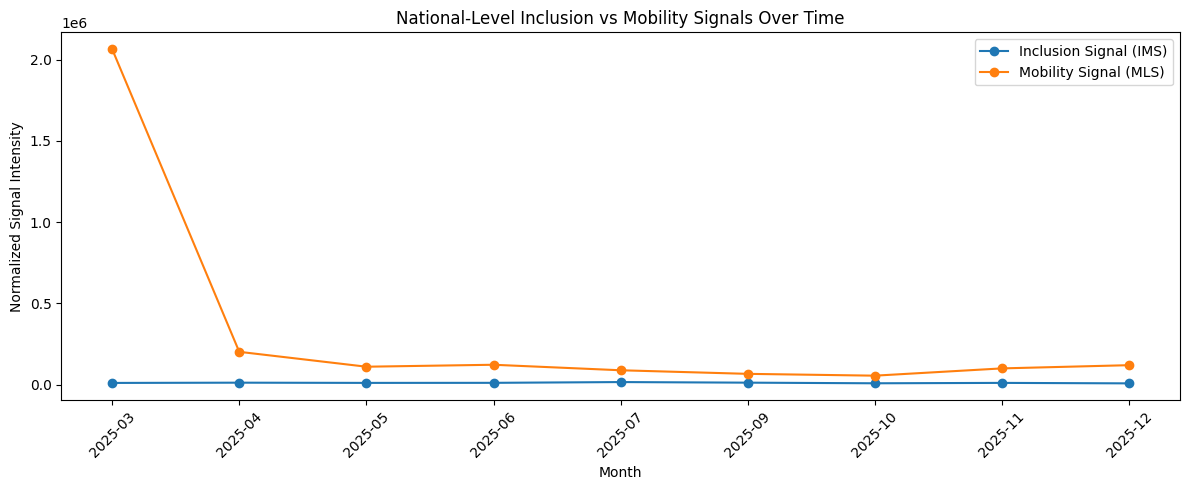

In [269]:
plt.figure(figsize=(12,5))
plt.plot(monthly_trends["year_month"].astype(str),
         monthly_trends["IMS_norm"],
         label="Inclusion Signal (IMS)", marker="o")

plt.plot(monthly_trends["year_month"].astype(str),
         monthly_trends["MLS_norm"],
         label="Mobility Signal (MLS)", marker="o")

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Normalized Signal Intensity")
plt.title("National-Level Inclusion vs Mobility Signals Over Time")
plt.legend()
plt.tight_layout()
plt.show()


### Observations

- The inclusion signal (IMS) exhibits relatively stable behaviour over time,
  indicating steady identity enrolment activity.
- The mobility signal (MLS) shows higher volatility, with periods of sharp
  increase, suggesting episodic surges in demographic update activity.
- The divergence between IMS and MLS highlights that mobility-related activity
  does not necessarily coincide with new enrolment.



The initial spike in mobility signal reflects a concentrated period of
demographic update activity at the beginning of the observed window.
The framework intentionally does not attribute causality, treating this
as a baseline shock against which subsequent normalization and volatility
are measured.



## District-Level Signal Interaction and Divergence

While national averages provide a macro view, societal transitions often emerge
unevenly across regions. We therefore examine the interaction between inclusion
and mobility signals at the district level to identify divergent behavioural
patterns.


In [270]:
district_profile = (
    signals_dist
    .groupby(["state", "district"])[["IMS_norm", "MLS_norm"]]
    .mean()
    .reset_index()
)

district_profile.head()


,state,district,IMS_norm,MLS_norm
0,Andaman and Nicobar Islands,Andamans,8725.11,92971.00
1,Andaman and Nicobar Islands,Nicobar,5481.54,35163.88
2,Andaman and Nicobar Islands,North And Middle Andaman,9778.79,86472.01
3,Andaman and Nicobar Islands,South Andaman,9459.99,136837.40
4,Andhra Pradesh,Adilabad,6858.50,139218.90


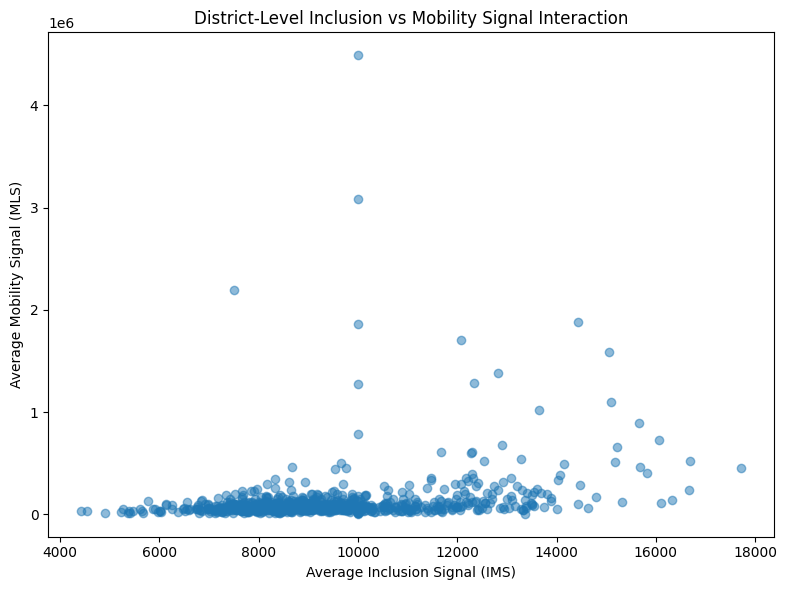

In [271]:
plt.figure(figsize=(8,6))
plt.scatter(
    district_profile["IMS_norm"],
    district_profile["MLS_norm"],
    alpha=0.5
)

plt.xlabel("Average Inclusion Signal (IMS)")
plt.ylabel("Average Mobility Signal (MLS)")
plt.title("District-Level Inclusion vs Mobility Signal Interaction")
plt.tight_layout()
plt.show()


### Interpretation of Signal Interaction

- Districts with relatively high mobility signals but moderate inclusion signals
  exhibit mobility-consistent behaviour without corresponding new enrolment.
- Districts with balanced inclusion and mobility signals reflect stable and
  mature identity engagement.
- Extreme outliers indicate regions experiencing unusually high update activity,
  warranting closer operational attention.


## Identifying Societal Stress Zones

Beyond average signal intensity, regions experiencing rapid fluctuations in
mobility-related activity may indicate periods of transition or operational
stress.

We identify such regions by examining the temporal volatility of the mobility
signal at the district level.


In [272]:
district_volatility = (
    signals_dist
    .groupby(["state", "district"])["MLS_norm"]
    .std()
    .reset_index(name="MLS_volatility")
)

district_volatility.head()


,state,district,MLS_volatility
0,Andaman and Nicobar Islands,Andamans,56106.46
1,Andaman and Nicobar Islands,Nicobar,11577.15
2,Andaman and Nicobar Islands,North And Middle Andaman,37903.72
3,Andaman and Nicobar Islands,South Andaman,83647.74
4,Andhra Pradesh,Adilabad,55391.75


In [273]:
district_volatility["MLS_volatility"].describe()


,MLS_volatility
count,918.00
mean,94340.16
std,333240.16
min,1000.68
25%,17206.86
50%,25436.24
75%,47485.95
max,5292771.66


In [274]:
threshold = district_volatility["MLS_volatility"].quantile(0.95)

stress_zones = district_volatility[
    district_volatility["MLS_volatility"] >= threshold
].sort_values("MLS_volatility", ascending=False)

stress_zones.head(10)


,state,district,MLS_volatility
519,Maharashtra,Thane,5292771.66
205,Delhi,North West Delhi,3741874.90
830,Uttar Pradesh,Gorakhpur,3593615.88
135,Bihar,Muzaffarpur,2799003.58
139,Bihar,Patna,2549462.73
117,Bihar,Bhagalpur,2382655.58
317,Jharkhand,Deoghar,2133922.63
816,Uttar Pradesh,Bulandshahr,2128452.08
673,Rajasthan,Jalore,1537957.25
251,Gujarat,Vadodara,1365418.08


### Interpretation of Stress Zones

Districts exhibiting high volatility in mobility signals experience sharp,
episodic changes in demographic update activity.

These patterns may reflect periods of intensified administrative interaction,
policy-driven update drives, or localized societal transitions, and can be
used to prioritize operational attention without inferring causality.


## Early-Warning Alert Framework

To translate societal signals into operational action, we define a simple,
transparent alerting mechanism based on deviations from historical baselines.

The goal is not automated decision-making, but structured prioritization
for human-led intervention.


In [275]:
district_baselines = (
    signals_dist
    .groupby(["state", "district"])["MLS_norm"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "MLS_mean", "std": "MLS_std"})
)

district_baselines.head()


,state,district,MLS_mean,MLS_std
0,Andaman and Nicobar Islands,Andamans,92971.00,56106.46
1,Andaman and Nicobar Islands,Nicobar,35163.88,11577.15
2,Andaman and Nicobar Islands,North And Middle Andaman,86472.01,37903.72
3,Andaman and Nicobar Islands,South Andaman,136837.40,83647.74
4,Andhra Pradesh,Adilabad,139218.90,55391.75


In [276]:
signals_alert = signals_dist.merge(
    district_baselines,
    on=["state", "district"],
    how="left"
)

signals_alert.head()


,year_month,state,district,age_0_5,age_5_17,age_18_greater,IMS,MLS,pop_proxy,IMS_norm,MLS_norm,MLS_mean,MLS_std
0,2025-09,Andaman and Nicobar Islands,Andamans,23,4,0,27,162,27.00,10000.00,60000.00,92971.00,56106.46
1,2025-10,Andaman and Nicobar Islands,Andamans,15,0,0,15,75,21.00,7142.86,35714.29,92971.00,56106.46
2,2025-11,Andaman and Nicobar Islands,Andamans,13,0,0,13,212,18.33,7090.91,115636.36,92971.00,56106.46
3,2025-12,Andaman and Nicobar Islands,Andamans,19,1,0,20,301,18.75,10666.67,160533.33,92971.00,56106.46
4,2025-09,Andaman and Nicobar Islands,Nicobar,41,6,0,47,151,47.00,10000.00,32127.66,35163.88,11577.15


In [277]:
def generate_alert(row):
    if row["MLS_norm"] > row["MLS_mean"] + 3 * row["MLS_std"]:
        return "CRITICAL: Immediate operational attention"
    elif row["MLS_norm"] > row["MLS_mean"] + 2 * row["MLS_std"]:
        return "HIGH: Prepare additional capacity"
    elif row["MLS_norm"] > row["MLS_mean"] + row["MLS_std"]:
        return "MODERATE: Monitor closely"
    else:
        return "NORMAL"


In [278]:
signals_alert["alert_level"] = signals_alert.apply(generate_alert, axis=1)

signals_alert[["year_month", "state", "district", "MLS_norm", "alert_level"]].head()


,year_month,state,district,MLS_norm,alert_level
0,2025-09,Andaman and Nicobar Islands,Andamans,60000.00,NORMAL
1,2025-10,Andaman and Nicobar Islands,Andamans,35714.29,NORMAL
2,2025-11,Andaman and Nicobar Islands,Andamans,115636.36,NORMAL
3,2025-12,Andaman and Nicobar Islands,Andamans,160533.33,MODERATE: Monitor closely
4,2025-09,Andaman and Nicobar Islands,Nicobar,32127.66,NORMAL


In [279]:
signals_alert["alert_level"].value_counts()


,count
alert_level,
NORMAL,3297
MODERATE: Monitor closely,753
HIGH: Prepare additional capacity,51


In [280]:
latest_month = signals_alert["year_month"].max()

current_alerts = (
    signals_alert[signals_alert["year_month"] == latest_month]
    .query("alert_level != 'NORMAL'")
    .sort_values("alert_level")
)

current_alerts.head(10)


,year_month,state,district,age_0_5,age_5_17,age_18_greater,IMS,MLS,pop_proxy,IMS_norm,MLS_norm,MLS_mean,MLS_std,alert_level
3,2025-12,Andaman and Nicobar Islands,Andamans,19,1,0,20,301,18.75,10666.67,160533.33,92971.00,56106.46,MODERATE: Monitor closely
2729,2025-12,Punjab,Barnala,136,10,1,147,2619,253.25,5804.54,103415.60,80337.66,18717.47,MODERATE: Monitor closely
2718,2025-12,Puducherry,Yanam,7,0,0,7,110,8.25,8484.85,133333.33,81870.78,39828.29,MODERATE: Monitor closely
2714,2025-12,Puducherry,Puducherry,218,13,13,244,4804,332.50,7338.35,144481.20,98274.98,35969.16,MODERATE: Monitor closely
2710,2025-12,Puducherry,Pondicherry,110,6,0,116,1942,271.75,4268.63,71462.74,48795.31,17890.62,MODERATE: Monitor closely
2706,2025-12,Puducherry,Karaikal,69,3,3,75,1521,141.75,5291.01,107301.59,74337.34,28748.99,MODERATE: Monitor closely
2702,2025-12,Odisha,Sundergarh,596,88,4,688,7176,1000.25,6878.28,71742.06,48477.46,17217.17,MODERATE: Monitor closely
2698,2025-12,Odisha,Sundargarh,109,15,0,124,2279,182.50,6794.52,124876.71,84642.97,28381.00,MODERATE: Monitor closely
2694,2025-12,Odisha,Subarnapur,43,6,0,49,822,101.25,4839.51,81185.19,53950.68,19061.96,MODERATE: Monitor closely
2690,2025-12,Odisha,Sonapur,179,26,1,206,2286,377.50,5456.95,60556.29,43190.20,13482.63,MODERATE: Monitor closely


### Interpretation of Alerts

The alert framework highlights districts experiencing signal intensity
significantly above their historical baseline.

Alerts are relative to each district’s own behavior, enabling fair comparison
without imposing uniform national thresholds.

This approach supports early operational awareness while preserving
human oversight and contextual decision-making.


## Short-Horizon Signal Forecasting (Early-Warning Extension)

To extend the societal seismograph from detection to anticipation, we perform
short-horizon forecasting of the **mobility signal (MLS)** at the national level.

The objective is not long-term prediction, but early indication of potential
signal surges that may warrant operational preparedness.


In [281]:
# Prepare national-level monthly MLS signal
national_mls = (
    signals_dist
    .groupby("year_month")["MLS_norm"]
    .mean()
    .reset_index()
)

# Convert period to timestamp
national_mls["ds"] = national_mls["year_month"].dt.to_timestamp()
national_mls["y"] = national_mls["MLS_norm"]

national_mls = national_mls[["ds", "y"]]
national_mls.head()


,ds,y
0,2025-03-01,2066109.54
1,2025-04-01,201546.06
2,2025-05-01,109883.94
3,2025-06-01,121942.34
4,2025-07-01,87985.63


In [282]:
from prophet import Prophet


In [283]:
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.80
)

model.fit(national_mls)


INFO:prophet:n_changepoints greater than number of observations. Using 6.


In [284]:
future = model.make_future_dataframe(periods=3, freq="M")
forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(6)


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
6,2025-10-01,40951.16,-601685.41,701269.43
7,2025-11-01,-72631.55,-733422.35,620740.95
8,2025-12-01,-182550.30,-800112.67,440135.28
9,2025-12-31,-292469.06,-966365.58,363981.07
10,2026-01-31,-406051.77,-1069532.42,260670.97
11,2026-02-28,-508642.60,-1193910.12,117036.71


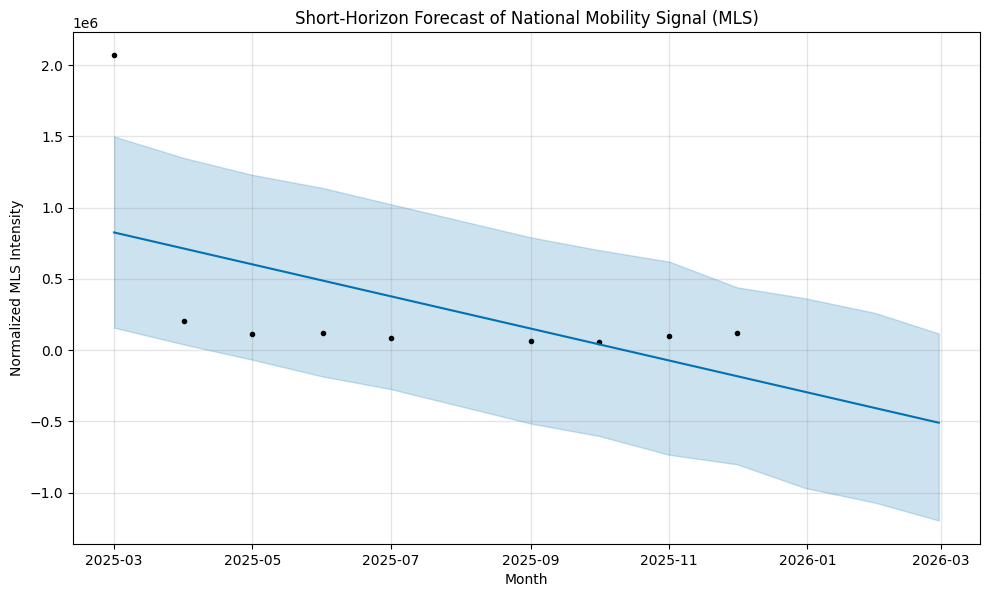

In [285]:
model.plot(forecast)
plt.title("Short-Horizon Forecast of National Mobility Signal (MLS)")
plt.xlabel("Month")
plt.ylabel("Normalized MLS Intensity")
plt.show()


### Forecast Interpretation

- The forecast provides a short-horizon view of expected mobility signal
  intensity under recent trends.
- Uncertainty bands reflect signal volatility rather than deterministic outcomes.
- This enables UIDAI to anticipate periods of elevated activity and prepare
  operational capacity accordingly.

This forecast is intended for preparedness, not causal inference.


Note: Forecast values are centered around recent signal trends. Negative values
indicate relative signal relaxation below the recent baseline rather than
negative real-world activity.


Together, the signal detection, forecasting, and alerting components form an
end-to-end early-warning framework for Aadhaar system planning.


## **Actionable Insights for UIDAI**

The societal signal framework developed in this analysis demonstrates how Aadhaar
enrolment and demographic update data can be leveraged as a decision-support tool
for **operational planning, infrastructure readiness, and service optimization**.

Rather than relying on reactive reporting, the framework enables UIDAI to
proactively identify regions experiencing elevated interaction intensity and
prepare appropriate responses.

---

### **1. Proactive Operational Planning**

Districts exhibiting **high volatility in mobility signals** can be prioritized
for operational preparedness, including:

- Temporary reinforcement of staffing capacity  
- Scaling of update center infrastructure during peak periods  
- Load-aware scheduling to reduce congestion and service delays  

---

### **2. Targeted Outreach and Awareness**

Regions showing **sustained mobility-related activity without corresponding new
enrolment** may benefit from focused engagement strategies, such as:

- Targeted awareness and information campaigns  
- Simplified and clearer update workflows  
- Improved communication regarding update requirements and procedures  

---

### **3. Early-Warning Monitoring Framework**

The signal-based approach can be operationalized as an **early-warning framework**
through:

- A monthly monitoring dashboard tracking inclusion and mobility signals  
- Automated alerts triggered by statistically significant deviations from
  district-specific baselines  
- Region-specific thresholds that account for local behavior rather than relying
  on uniform national averages  

---

## **Limitations and Responsible Use**

- The signals identified in this analysis are **indicative and non-causal** in
  nature.  
- All analysis is based solely on **aggregated, anonymized data** and does not
  reflect individual behavior.  
- External validation using complementary datasets (such as census or mobility
  indicators) would further strengthen interpretation.  

This framework is intended to **support proactive governance and operational
preparedness**, not to infer individual or community-level characteristics.

---

## **Conclusion**

This project demonstrates how Aadhaar enrolment and demographic update data can be
reframed from static reporting metrics into **societal signals**.

By modeling inclusion and mobility interactions across time and geography, the
framework identifies early transitions and regional stress zones in a manner that
is **ethical, interpretable, and policy-relevant**.

Overall, the analysis highlights Aadhaar’s potential to function as a **passive
societal seismograph**, supporting informed and proactive decision-making for UIDAI.

---


> *“We transform Aadhaar data from a reactive reporting system into an ethical,
> early-warning framework for proactive governance.”*
